In [30]:
import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yaml

from bandit_sim.configs import AlgorithmConfig, BanditEnvConfig
from bandit_sim.setting import Settings, generate_base_filename

In [31]:
result_dir = "20250817-1810-alignment"
output_dir = os.path.join("../output/", result_dir)

config = {}

with open(os.path.join(output_dir, "simulation_config.yaml"), "r") as config_file:
    raw_dict = yaml.full_load(config_file)  # TODO: Make config loadable.
    for k, v in raw_dict.items():
        if k == "bandit_env_config":
            config_value = BanditEnvConfig.model_validate(v)
        elif k == "algorithm_configs":
            config_value = [AlgorithmConfig.model_validate(alg_dict) for alg_dict in v]
        elif k == "settings":
            config_value = Settings(**v)
        else:
            config_value = v

        config[k] = config_value

settings: Settings = config["settings"]
algorithms: list[AlgorithmConfig] = config["algorithm_configs"]
bandit_env_config = config["bandit_env_config"]
bandit_env_name = config["bandit_env_name"]

# config
T = settings.T
trials = settings.num_trials
K = settings.num_arms
base_seed = settings.base_seed

num_trials = settings.num_trials
trial_id_overrides = settings.trial_id_overrides

if trial_id_overrides is not None and len(trial_id_overrides) > 0:
    trial_ids = trial_id_overrides
    num_trials = len(trial_ids)
else:
    trial_ids = range(num_trials)

num_algs = len(algorithms)
K_env = K // 2

In [32]:
raw_df = pl.DataFrame()

for i, trial_id in enumerate(trial_ids):
    filename = generate_base_filename(base_seed, trial_id)
    with open(os.path.join(output_dir, f"data_{filename}"), "rb") as f:
        raw_df.vstack(pl.read_parquet(f), in_place=True)

raw_df

reward,action,info_ratio,algorithm,time_step,regret,trial
f64,u8,f64,cat,u32,f64,u16
0.754664,12,1.253482,"""IDS""",0,-0.094832,0
0.260772,10,1.250751,"""IDS""",1,0.304228,0
0.144538,3,1.25406,"""IDS""",2,0.819521,0
0.491278,0,1.256911,"""IDS""",3,0.988075,0
0.369309,14,1.257277,"""IDS""",4,1.278598,0
…,…,…,…,…,…,…
0.04266,7,null,"""TS-ep1""",99995,6912.82476,7
0.95734,7,null,"""TS-ep1""",99996,6912.722626,7
0.95734,7,null,"""TS-ep1""",99997,6912.620491,7


In [33]:
aggregated_df = (
    raw_df.group_by("algorithm", "time_step")
    .agg(
        pl.col("regret").mean().alias("regret mean"),
        pl.col("regret").std().alias("regret std"),
        pl.col("info_ratio").mean().alias("info ratio mean"),
        pl.col("info_ratio").std().alias("info ratio std"),
    )
    .sort("time_step")
)

grouped_df = aggregated_df.group_by("algorithm")

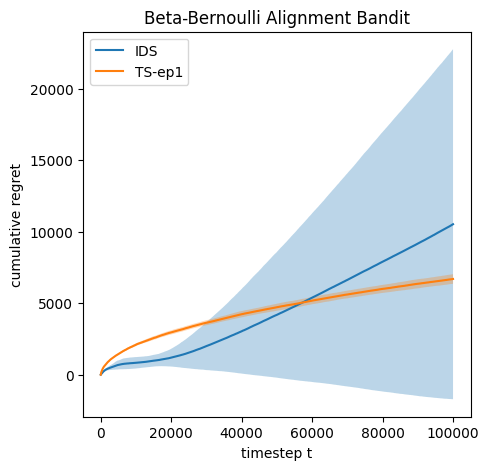

In [34]:
"""
Section below is for plotting
"""
title = bandit_env_name
output = bandit_env_config.label

plt.figure(figsize=(5, 5))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )
# for i in range(num_trials):
#     for alg in range(num_algs):
#         plt.plot(all_regrets[i][alg], color="blue", alpha=0.3)

# for alg in range(num_algs):
#     plt.plot(regret_means[alg], label=algorithms[alg].label)
# plt.xlim(left=0, right=T)
plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

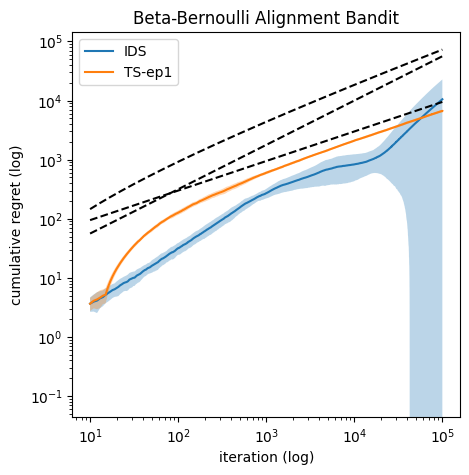

In [35]:
# log log plot
plt.figure(figsize=(5, 5))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(10, T),
        means[10:],
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means[10:] + stds[10:],
        means[10:] - stds[10:],
        alpha=0.3,
    )
# lines for comparison
x = np.arange(10, T)
sqrt_x = 30 * np.sqrt(x)
sqrt_x_log_x = 20 * np.sqrt(x) * np.log(x)
x_3_4 = 10 * x ** (3 / 4)

# plt.plot(x, x, "k--")
plt.plot(x, sqrt_x, "k--")
plt.plot(x, sqrt_x_log_x, "k--")
plt.plot(x, x_3_4, "k--")
# plt.xlim(left=0, right=T)
# plt.ylim(bottom=0, top=120)
plt.title(title)
plt.xlabel("iteration (log)")
plt.ylabel("cumulative regret (log)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [43]:
df_human_actions = (
    raw_df.with_columns(
        pl.when(pl.col("action") < K_env)
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
        .alias("human action")
    )
    .with_columns(
        pl.col("human action")
        .cum_sum()
        .over("algorithm", "trial", order_by="time_step")
        .alias("cumulative human action")
    )
    .group_by("algorithm", "time_step")
    .agg(
        pl.col("cumulative human action").mean().alias("mean cum human action"),
        pl.col("cumulative human action").std().alias("std cum human action"),
    )
    .sort("time_step")
)

df_human_actions_grouped = df_human_actions.group_by("algorithm")

df_human_actions

algorithm,time_step,mean cum human action,std cum human action
cat,u32,f64,f64
"""TS-ep1""",0,0.0,0.0
"""IDS""",0,0.0,0.0
"""TS-ep1""",1,0.0,0.0
"""IDS""",1,0.0,0.0
"""IDS""",2,0.0,0.0
…,…,…,…
"""TS-ep1""",99997,3520.625,58.600189
"""IDS""",99998,1784.125,2273.081573
"""TS-ep1""",99998,3520.625,58.600189


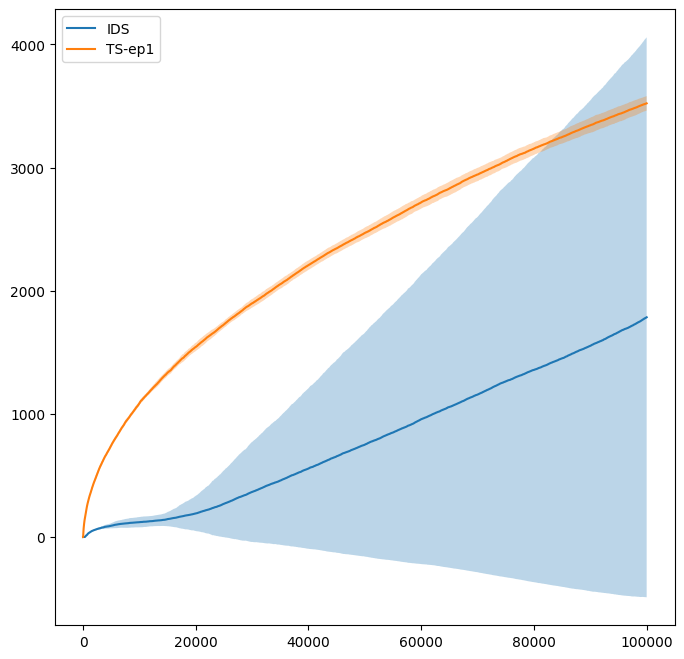

In [44]:
plt.figure(figsize=(8, 8))

for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"]
    stds = data["std cum human action"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.legend()
plt.show()

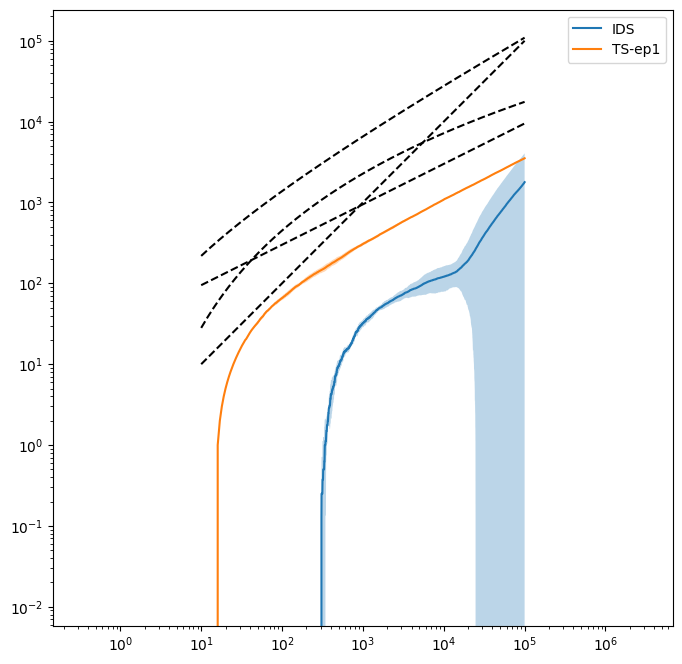

In [50]:
plt.figure(figsize=(8, 8))
for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"][10:]
    stds = data["std cum human action"][10:]
    plt.plot(
        np.arange(10, T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

sqrt_t = np.sqrt(np.arange(10, T))
sqrt_t_log_t = np.sqrt(np.arange(10, T)) * np.log(np.arange(10, T))
log_t = np.log(np.arange(10, T)) * np.log(np.arange(10, T))

plt.plot(np.arange(10, T), np.arange(10, T), color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.legend()
plt.show()